Get an idea what are the deforestation years in the geo-wiki dataset (based on Hansen global map)

In [7]:
import geopandas as gpd
import pandas as pd
import rasterio
import os
from pathlib import Path
from shapely.geometry import Polygon
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

In [6]:
gdf = pd.read_csv('data/ILUC_DARE_x_y/ILUC_DARE_campaign_x_y.csv')


In [10]:
gdf.head(10)

,userid,submissionid,timestamp,sampleid,skip,viewed_ge,samplegroupid,used_basemap,submission_itemid,legendid,...,comments,score_ctrl,qual_score,rank_ini,rqs,addedpts,newqs,rank_final,x,y
0,19785,2077985,11DEC20:11:41:38,1600888,0,0,229,2,58674875.0,301.0,...,NaN,NaN,27724.0,11.0,0.88,20000.0,47724.0,8.0,97.923927,26.256042
1,19785,2077985,11DEC20:11:41:38,1600888,0,0,229,2,58674876.0,299.0,...,NaN,NaN,27724.0,11.0,0.88,20000.0,47724.0,8.0,97.923927,26.256042
2,21900,2078679,11DEC20:11:58:54,1600888,0,0,229,1,58676981.0,298.0,...,NaN,NaN,17583.0,17.0,0.82,20000.0,37583.0,15.0,97.923927,26.256042
3,21900,2078679,11DEC20:11:58:54,1600888,0,0,229,1,58676982.0,301.0,...,NaN,NaN,17583.0,17.0,0.82,20000.0,37583.0,15.0,97.923927,26.256042
4,21900,2078679,11DEC20:11:58:54,1600888,0,0,229,1,58676983.0,299.0,...,NaN,NaN,17583.0,17.0,0.82,20000.0,37583.0,15.0,97.923927,26.256042
5,21576,2078825,11DEC20:12:03:42,1600889,0,0,229,1,58677423.0,298.0,...,NaN,NaN,28776.0,10.0,0.71,NaN,28776.0,17.0,107.481103,15.599328
6,21576,2078825,11DEC20:12:03:42,1600889,0,0,229,1,58677424.0,301.0,...,NaN,NaN,28776.0,10.0,0.71,NaN,28776.0,17.0,107.481103,15.599328
7,21576,2078825,11DEC20:12:03:42,1600889,0,0,229,1,58677425.0,299.0,...,NaN,NaN,28776.0,10.0,0.71,NaN,28776.0,17.0,107.481103,15.599328
8,21900,2077602,11DEC20:11:33:40,1600889,0,0,229,1,58673717.0,298.0,...,NaN,NaN,17583.0,17.0,0.82,20000.0,37583.0,15.0,107.481103,15.599328
9,21900,2077602,11DEC20:11:33:40,1600889,0,0,229,1,58673718.0,301.0,...,NaN,NaN,17583.0,17.0,0.82,20000.0,37583.0,15.0,107.481103,15.599328


In [2]:
controls = pd.read_csv('data/ILUC_DARE_x_y/ILUC_DARE_controls_x_y.csv')

controls_gdf = gpd.GeoDataFrame(controls,
                     geometry=gpd.points_from_xy(controls.x, controls.y))    


controls_gdf.crs = 4326
#3857 projection has meter units (for buffering) and should work ok around the equator
controls_gdf_proj = controls_gdf.to_crs(3857)
squares = controls_gdf_proj.geometry.buffer(500, cap_style=3).to_crs(4326)

controls_gdf['geometry'] = squares

In [5]:
controls.head()

,sampleid,legendid,step,name,answer,x,y,geometry
0,1740347,301,step3,"Can you see roads, trails or buildings in the ...",Yes,122.612326,9.604870,"POLYGON ((122.61682 9.60930, 122.61682 9.60044..."
1,1740347,298,step1,Please select the predominant tree loss driver...,Subsistence agriculture,122.612326,9.604870,"POLYGON ((122.61682 9.60930, 122.61682 9.60044..."
2,1740347,299,step2,Please select all other tree loss drivers visi...,Roads/trails/buildings,122.612326,9.604870,"POLYGON ((122.61682 9.60930, 122.61682 9.60044..."
3,1739108,299,step2,Please select all other tree loss drivers visi...,Roads/trails/buildings,-37.796241,-12.070579,"POLYGON ((-37.79175 -12.06619, -37.79175 -12.0..."
4,1739108,301,step3,"Can you see roads, trails or buildings in the ...",Yes,-37.796241,-12.070579,"POLYGON ((-37.79175 -12.06619, -37.79175 -12.0..."


In [3]:
locations = controls_gdf.loc[controls_gdf.step == 'step1'].copy()

In [4]:
hansen_dir = '/Users/janpisl/Documents/EPFL/Hansen_yearloss/'


In [5]:
def parse_lat(latitude: str) -> tuple:

    assert ("S" in latitude or "N" in latitude), 'Unexpected name format'
    if "S" in latitude:
        max_lat = int(latitude.split("S")[0]) * -1
    else:
        max_lat = int(latitude.split("N")[0])
    min_lat = max_lat - 10

    return min_lat, max_lat

def parse_lon(longitude: str) -> tuple:
    assert ("W" in longitude or "E" in longitude), 'Unexpected name format'
    if "W" in longitude:
        max_lon = int(longitude.split("W")[0]) * -1       
    else:
        max_lon = int(longitude.split("E")[0])    
    min_lon = max_lon + 10

    return min_lon, max_lon

def get_extent(filename):
    _, _, _, lat, lon = filename.split('_')

    min_lat, max_lat = parse_lat(lat)
    min_lon, max_lon = parse_lon(lon)

    return min_lat, max_lat, min_lon, max_lon


In [6]:
shapes = []
filenames = []
for filename in os.listdir(hansen_dir):
    if not filename.endswith('.tif'):
        continue

    min_lat, max_lat, min_lon, max_lon = get_extent(filename)
    polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat, ), (max_lon, min_lat )])
    shapes.append(polygon)
    filenames.append(filename)

<AxesSubplot:>

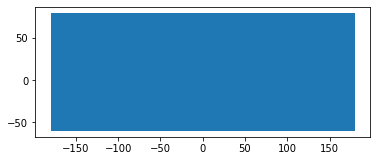

In [7]:
gdf = gpd.GeoDataFrame(filenames, geometry=shapes)
gdf.plot()

In [85]:
gdf.to_file("delete.shp")

/Users/janpisl/miniconda3/envs/gee/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In the next section, for each location with an annotated driver, the Hansen tile is found that intersects with it, then the Hansen tile is masked to get only values within the driver area (1x1km). Some info about the years of deforestation are then extracted 

In [8]:
geom = locations.iloc[1].geometry


In [13]:
gdf['filename'] = gdf[0]
gdf = gdf.drop([0], axis=1)

In [14]:
masks = []
for index, row in locations.iterrows():

    geom = row.geometry
    filename = gdf.loc[gdf.intersects(geom)].filename.values[0]
    with rasterio.open(os.path.join(hansen_dir, filename)) as src:
        out_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)

    out_image = out_image.flatten()
    masks.append(out_image)




1323.182908545727

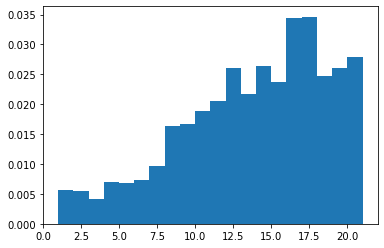

In [21]:
all = np.concatenate( masks, axis=0 )
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.hist(all, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],weights=np.ones(len(all)) / len(all))
plt.title("Deforestation year over all 2000 validation geo-wiki samples")
plt.show()

In [126]:
from matplotlib.ticker import PercentFormatter

for i in range(1,2000, 15):
    
    data = locations.iloc[i].hansen_years
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.hist(data, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],weights=np.ones(len(data)) / len(data))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    fig.savefig(f'plots/absolute_values/{i}.png', bbox_inches="tight")   # save the figure to file
    plt.close(fig)    # close the figure window




,sampleid,legendid,step,name,answer,x,y,geometry,year_histograms,hansen_years
1,1740347,298,step1,Please select the predominant tree loss driver...,Subsistence agriculture,122.612326,9.604870,"POLYGON ((122.61682 9.60930, 122.61682 9.60044...","([1276, 0, 1, 1, 7, 5, 9, 0, 22, 48], [0.0, 1....","[8, 8, 8, 8, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
5,1739108,298,step1,Please select the predominant tree loss driver...,Pasture,-37.796241,-12.070579,"POLYGON ((-37.79175 -12.06619, -37.79175 -12.0...","([1202, 0, 1, 45, 4, 16, 1, 9, 35, 19], [0.0, ...","[19, 10, 10, 10, 10, 10, 19, 19, 10, 10, 19, 1..."
6,1739666,298,step1,Please select the predominant tree loss driver...,Other natural disturbances/No tree-loss driver,-4.262132,9.700092,"POLYGON ((-4.25764 9.70452, -4.25764 9.69566, ...","([1363, 0, 0, 0, 0, 0, 0, 0, 0, 6], [0.0, 1.6,...","[16, 16, 16, 16, 16, 16]"
9,1739063,298,step1,Please select the predominant tree loss driver...,Subsistence agriculture,-51.525194,-26.045670,"POLYGON ((-51.52070 -26.04163, -51.52070 -26.0...","([1027, 8, 15, 1, 27, 2, 96, 28, 11, 6], [0.0,...","[17, 17, 17, 20, 20, 20, 6, 17, 17, 9, 17, 9, ..."
13,1738129,298,step1,Please select the predominant tree loss driver...,Subsistence agriculture,90.594572,25.690104,"POLYGON ((90.59906 25.69415, 90.59906 25.68606...","([1063, 3, 1, 2, 4, 4, 113, 3, 3, 25], [0.0, 2...","[14, 13, 14, 13, 13, 14, 14, 14, 14, 14, 14, 1..."
...,...,...,...,...,...,...,...,...,...,...
6144,1741075,298,step1,Please select the predominant tree loss driver...,Pasture,-70.200270,8.145108,"POLYGON ((-70.19578 8.14955, -70.19578 8.14066...","([1203, 0, 7, 75, 30, 5, 10, 0, 0, 39], [0.0, ...","[10, 10, 5, 5, 7, 7, 7, 7, 7, 7, 10, 5, 7, 7, ..."
6145,1739715,298,step1,Please select the predominant tree loss driver...,Managed forest/forestry,-84.427788,29.952610,"POLYGON ((-84.42330 29.95650, -84.42330 29.948...","([548, 0, 0, 0, 0, 0, 255, 3, 0, 415], [0.0, 1...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 9..."
6150,1739505,298,step1,Please select the predominant tree loss driver...,Pasture,-51.503634,-9.209445,"POLYGON ((-51.49914 -9.20501, -51.49914 -9.213...","([629, 0, 0, 2, 0, 1, 16, 439, 155, 90], [0.0,...","[17, 14, 14, 14, 18, 18, 14, 17, 17, 17, 17, 1..."
6153,1739129,298,step1,Please select the predominant tree loss driver...,Subsistence agriculture,104.939769,16.243420,"POLYGON ((104.94426 16.24773, 104.94426 16.239...","([897, 0, 1, 53, 46, 94, 125, 37, 0, 42], [0.0...","[12, 12, 12, 12, 12, 20, 21, 21, 21, 21, 12, 1..."


In [12]:
landsat_dir = '/Users/janpisl/Documents/EPFL/drivers/data/landsat_controls'

dates = []

files = os.listdir(landsat_dir)
files.sort()

for file in files:
    year, index = file.split('.')[0].split("_")[-2:]
    idx = int(index)/2 - 0.5

    date = int(year) + idx
    dates.append(date)

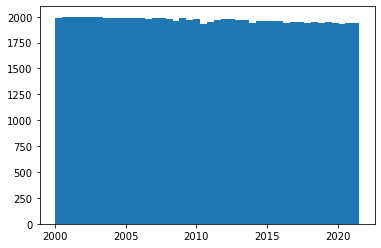

In [18]:
data = plt.hist(dates, bins=44)

Text(0.5, 1.0, 'Number of locations (out of 2000) where an image is missing for particular 6-months period')

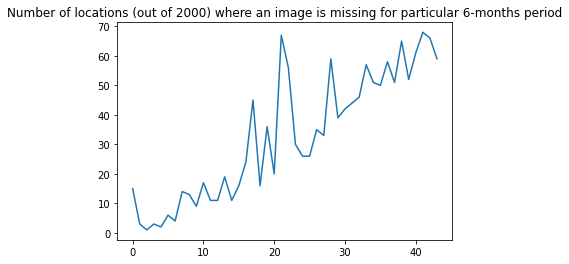

In [24]:
plt.plot(2001 - data[0])
plt.title("Number of locations (out of 2000) where an image is missing for particular 6-months period")

In [23]:
2001 - data[0]

array([15.,  3.,  1.,  3.,  2.,  6.,  4., 14., 13.,  9., 17., 11., 11.,
       19., 11., 16., 24., 45., 16., 36., 20., 67., 56., 30., 26., 26.,
       35., 33., 59., 39., 42., 44., 46., 57., 51., 50., 58., 51., 65.,
       52., 61., 68., 66., 59.])